# Tools 2 Final Project

Jen Lee
Connie Chang

In [3]:
import pandas as pd
import geopandas as gpd
import re
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

## Data Gathering

#### AirBnb Data

Source: http://insideairbnb.com/get-the-data.html

|Date Compiled |County/City|File Name   |Description |
|:-------------|:---------:|:----------:|-----------:|
|29 March, 2021|Denver     |listings.csv|Summary information and metrics for listings in Denver (good for visualisations).|
|29 March, 2021|Denver     |reviews.csv|Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).|
|N/A|Denver     |neighbourhoods.csv| Neighbourhood list for geo filter. Sourced from city or open source GIS files.|
|N/A|Denver     |neighbourhoods.geojson| GeoJSON file of neighbourhoods of the city.|

#### Other Data

|Source |File Name   |Description | URL |
|:-------------|:---------:|:----------:|-----------:|
|Wikipedia|neighbourhoods_den.csv   |Groups the Denver Neighbourhoods into Areas| https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Denver |



In [4]:
# listings.csv
listings = pd.read_csv("./data/denver_03_29_2021/listings.csv")
print(f"listings shape: {listings.shape}")
listings.sample(3)

listings shape: (3394, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1623,33667262,https://www.airbnb.com/rooms/33667262,20210329150448,2021-03-30,High-rise luxury condo in Downtown Denver,"Completely furnished 2 bedroom, 2 bath. Five p...",NaN,https://a0.muscache.com/pictures/07a79a44-f40d...,25519738,https://www.airbnb.com/users/show/25519738,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.56
468,13764044,https://www.airbnb.com/rooms/13764044,20210329150448,2021-04-04,CHERRY CREEK CHIC RETREAT🍒,Cherry Cheek North has won the #1 walking scor...,Cherry Creek North is one of the most sought a...,https://a0.muscache.com/pictures/1d81d02e-3b9e...,8751405,https://www.airbnb.com/users/show/8751405,...,10.0,10.0,10.0,2019-BFN-0001809,f,3,3,0,0,2.69
1302,28283929,https://www.airbnb.com/rooms/28283929,20210329150448,2021-03-30,Charming Sloan Lake Private Bedroom,Charming duplex home only 4 blocks south of Sl...,NaN,https://a0.muscache.com/pictures/4c48badf-4b91...,191010583,https://www.airbnb.com/users/show/191010583,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


In [3]:
# reviews.csv
reviews = pd.read_csv("./data/denver_03_29_2021/reviews.csv")
reviews.sample(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
110298,22305207,484398371,2019-07-08,35236385,Mark,This was the nicest Airbnb we have ever visite...
91015,19501629,358249597,2018-12-13,53435192,Loren,"Great location, parking was easy to find. Lots..."
104247,21630965,670575551,2020-10-03,313262072,Avisha,Super accommodating and understanding towards ...


In [4]:
# neighbourhoods.csv
neighborhoods = pd.read_csv("./data/denver_03_29_2021/neighbourhoods.csv")
neighborhoods.sample(3)

,neighbourhood_group,neighbourhood
7,NaN,Berkeley
24,NaN,Elyria Swansea
32,NaN,Hampden South


In [5]:
# neighbourhoods.geojson
neighborhoods_gdf = gpd.read_file("./data/denver_03_29_2021/neighbourhoods.geojson")
neighborhoods_gdf.sample(3)

,neighbourhood,neighbourhood_group,geometry
70,North Capitol Hill,None,"MULTIPOLYGON (((-104.97338 39.74378, -104.9733..."
26,Overland,None,"MULTIPOLYGON (((-104.98743 39.69663, -104.9874..."
64,Barnum,None,"MULTIPOLYGON (((-105.02514 39.72554, -105.0251..."


In [13]:
# neighbourhoods_den.csv
neighbourhoods_group = pd.read_csv("./data/neighbourhoods_den.csv")
neighbourhoods_group.sample(3)

,neighbourhood_cleansed,neighbourhood_group
66,Harvey Park,Southwest
37,Gateway - Green Valley Ranch,Northeast
78,Westwood,West


## Data Cleaning

In [6]:
# remove unneeded columns from listings 
listings.drop(columns=["picture_url", "host_url", "host_thumbnail_url", "host_picture_url", "license", 'scrape_id', 
               'listing_url','last_scraped', 'neighborhood_overview','host_verifications' ,
               'host_about', 'host_thumbnail_url','host_neighbourhood', 'neighbourhood', 'name',
               'description','host_name', 'calendar_last_scraped'], axis=1, inplace=True)

In [7]:
# Clean up the "bathrooms_text" column to make two new columns - number of bathrooms, and a boolean column to indicate if bthrooms are private
def get_bathrooms_num(x):
    if type(x) != str:
        return 0.0
    elif x == "Shared half-bath" or x == "Half-bath":
        return 0.5
    elif "shared bath" in x:
        return float(x.strip("s").strip("shared bath"))
    elif "private bath" in x:
        return float(x.strip("s").strip("private bath"))
    elif "bath" in x:
        return float(x.strip("s").strip("bath"))
    else:
        return 0.0
    
# Returns "t" & "f" beacuse that's how the other booleans are formatted
def get_is_private_bathroom(x):
    if type(x) != str:
        return np.NaN
    elif "shared" in x:
        return "f"
    else:
        return "t"

listings["bathrooms"] = listings["bathrooms_text"].apply(lambda x: get_bathrooms_num(x))
listings["private_bathroom"] = listings["bathrooms_text"].apply(lambda x: get_is_private_bathroom(x))
listings = listings.drop("bathrooms_text", axis=1)

In [8]:
# Convert the latitude & longitude values to Point() values, to be used later for plotting
listings["coordinates"] = [Point(xy) for xy in zip(listings.longitude, listings.latitude)]

In [9]:
# For amenities. We want to explode that array out and convert the types of amenity to a "t/f" column showing if they have that amenity

all_amenities = set()

# First build an array of all the amenity types
for index, row in listings.iterrows():
    # Convert String representation of list to a list
    amenities = row["amenities"].replace('"', '').strip('][').split(', ')
    for item in amenities:
        all_amenities.add(item)
    
all_amenities

{'1 space',
 '120\\ HDTV with Netflix',
 '2 burner stovetop electric stove',
 '2 spaces',
 '2-5 years old',
 '30\\ HDTV with Netflix',
 '30\\ HDTV with Roku',
 '32\\ HDTV with Amazon Prime Video',
 '32\\ HDTV with Apple TV',
 '32\\ HDTV with Netflix',
 '32\\ HDTV with premium cable',
 '36\\ HDTV with Netflix',
 '37\\ TV',
 '4-burner cooktop (above microwave) electric stove',
 '40\\ HDTV',
 '40\\ HDTV with Amazon Prime Video',
 '40\\ HDTV with Chromecast',
 '40\\ HDTV with Netflix',
 '40\\ HDTV with standard cable',
 '40\\ TV',
 '40\\ TV with Roku',
 '41\\ TV with Chromecast',
 '42\\ HDTV with Amazon Prime Video',
 '42\\ HDTV with HBO Max',
 '42\\ TV',
 '43\\ HDTV with Amazon Prime Video',
 '44\\ HDTV with Netflix',
 '45\\ HDTV with Amazon Prime Video',
 '45\\ HDTV with HBO Max',
 '46\\ HDTV with Amazon Prime Video',
 '46\\ HDTV with Netflix',
 '48\\ HDTV with standard cable',
 '49\\ HDTV with Roku',
 '5-10 years old',
 '50\\ HDTV with Amazon Prime Video',
 '50\\ HDTV with Netflix',
 '5

In [10]:
## oof, that's a lot of ameneites, lets try to simple it down by hand
amenities = ["Air conditioning", "BBQ grill", "Baby bath", "Baby monitor", "Baby safety gates", "Backyard", 
             "Beachfront", "Bidet", "Bikes", "Board games", "Breakfast", "Cable", "Coffee", "Crib", "Dishwasher", "Dryer",
             "Fire pit", "Free parking", "Free wifi", "Game console", "Gym", "HGTV", "Heating", "High chair", 
            "Hot tub", "Luggage dropoff allowed", "Netflix", "Pets allowed", "Piano", "Ping pong table", "Pool", 
             "Pool table", "private entrance", "Private gym", "Private pool", "Private sauna", "Sauna",
             "Shared hot tub", "Shared outdoor heated pool", "Shared outdoor heated rooftop pool", "Shared outdoor pool",
            "Shared pool", "Shared sauna", "TV", "Washer", "Wifi", "Window AC unit"]


# Because a lot of these amenities have multiple similar forms, we'll check for them recursively
def check_for_amenity(amenities_str, amenity_to_check_for):
    amenities_list = amenities_str.replace('"', '').strip('][').split(', ')
    # convert list to lower so it's easer to check
    amenities_list = [each_string.lower() for each_string in amenities_list]
    for al in amenities_list:
        if amenity_to_check_for.lower() in al:
            # Check for pool & pool table seperate so those are very different
            if amenity_to_check_for.lower() == "pool":
                if "pool table" in al:
                    return "f"
                return "t"
            return "t"
    return "f"

# Now create column for each amenity
for a in amenities:
    listings[a] = listings["amenities"].apply(lambda al: check_for_amenity(al, a))
            
listings = listings.drop("amenities", axis = 1)
listings[amenities].sample(3)

,Air conditioning,BBQ grill,Baby bath,Baby monitor,Baby safety gates,Backyard,Beachfront,Bidet,Bikes,Board games,...,Shared hot tub,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit
1022,t,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,t,f
935,t,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,t,f
1984,t,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,t,t,t,f


### Add neighbourhoods_group

In [14]:
# Merge neighbourhoods_group df into listings
listings = pd.merge(listings, neighbourhoods_group, on='neighbourhood_cleansed',  
         how='left', validate='m:1')

listings[['neighbourhood_cleansed','neighbourhood_group']].sample(5)

,neighbourhood_cleansed,neighbourhood_group
3203,Cole,North
1782,University,South
281,Civic Center,Central
1458,Villa Park,West
2121,Capitol Hill,Central


### Price Field
'price' field is with type: object. It needs to remove '$' and ',' then convert to numeric.

In [15]:
print(f"listing price initial type: {listings.price.dtype}")

# drop the record with price = 0
listings = listings[listings['price']!='$0.00']

# remove '$' and ','
listings['price'] = listings['price'].str.strip('$')
listings['price'] = listings['price'].str.replace(',', '')

# convert to numeric
listings['price'] = pd.to_numeric(listings['price'])

print(f"listing price after cleaning type: {listings.price.dtype}")

listings['price'].describe()

listing price initial type: object
listing price after cleaning type: float64


count    3393.000000
mean      157.756263
std       244.777158
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64

### Convert Data Types
1. Convert to numeric: ```host_response_rate``` and ```host_acceptance_rate``` are object, remove '%' and convert to numeric
2. Convert to Ordinal: ```host_since```, ```first_review```, ```last_review```

In [16]:
# Remove % sign and convert the data type to numeric
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str[:-1])
listings['host_acceptance_rate'] = pd.to_numeric(listings['host_acceptance_rate'].str[:-1])

# Datetime format:
listings.host_since = pd.to_datetime(listings.host_since, format='%Y-%m-%d')
listings.first_review = pd.to_datetime(listings.first_review, format='%Y-%m-%d')
listings.last_review = pd.to_datetime(listings.last_review, format='%Y-%m-%d')

# Fill NA with 03/29/2012 (date data was scraped since we know they were at least a host since then)
listings['host_since'] = listings['host_since'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['first_review'] = listings['first_review'].fillna(pd.datetime(year=2021, month=3, day=29))
listings['last_review'] = listings['last_review'].fillna(pd.datetime(year=2021, month=3, day=29))

# To Ordinal
listings['host_since'] = listings['host_since'].apply(lambda x: x.toordinal())
listings['first_review'] = listings['first_review'].apply(lambda x: x.toordinal())
listings['last_review'] = listings['last_review'].apply(lambda x: x.toordinal())

C:\Users\Connie Chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Connie Chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':
C:\Users\Connie Chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]


### Fill in NA
1. ```Bedrooms``` field with blank are the ones that either a studio, or an open space without separate room as a bedroom, so we fill it with 0.
2. ```Beds``` field with blank typically means that the listing host missed the field. The main point of airbnb is bed, we'd assume they have at least 1 bed, so fill in the blank ones with 1.
3. ```Reviews_per_month``` field with blank means there's no review at all. Thus, the ```first_review``` and ```last_review``` fields are both blank. We'd fill the ```reviews_per_month``` with 0.
4. Fill numerical columns with mean. (process before modeling)
5. Fill categorical columns with 'missing'.

In [17]:
# FunctionTransformer for fill NA 
from sklearn.preprocessing import FunctionTransformer
def custom_transformation(df):
    df['bedrooms'].fillna(0, inplace=True)
    df['beds'].fillna(1, inplace=True)
    df['reviews_per_month'].fillna(0, inplace=True)

ft = FunctionTransformer(func=custom_transformation, validate=False)
ft.fit_transform(listings)

In [18]:
# Categorical columns :
# Drop coortinates then get any remaining columns
catFeatures = listings.drop(['coordinates'], axis=1).select_dtypes(include=['object']).columns
catFeatures

Index(['host_location', 'host_response_time', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'has_availability', 'instant_bookable', 'private_bathroom',
       'Air conditioning', 'BBQ grill', 'Baby bath', 'Baby monitor',
       'Baby safety gates', 'Backyard', 'Beachfront', 'Bidet', 'Bikes',
       'Board games', 'Breakfast', 'Cable', 'Coffee', 'Crib', 'Dishwasher',
       'Dryer', 'Fire pit', 'Free parking', 'Free wifi', 'Game console', 'Gym',
       'HGTV', 'Heating', 'High chair', 'Hot tub', 'Luggage dropoff allowed',
       'Netflix', 'Pets allowed', 'Piano', 'Ping pong table', 'Pool',
       'Pool table', 'private entrance', 'Private gym', 'Private pool',
       'Private sauna', 'Sauna', 'Shared hot tub',
       'Shared outdoor heated pool', 'Shared outdoor heated rooftop pool',
       'Shared outdoor pool', 'Shared pool', 'Shared sauna', 'TV', 'Washer',
       'Wifi', 'Window AC 

In [19]:
listings[catFeatures] = listings[catFeatures].fillna('missing') # fill categorical columns with 'missing'

### Dropping Any Remaining Data that can't be Cleaned
1. Drop all NA columns ```neighbourhood_group_cleansed```, ```calendar_updated```
2. There are 4 records with NA in the ```bathrooms_text``` field, which be previously convertyed to ```private_bathroom```.
3. Drop records with NA in ```host_identity_verified``` as these may not be verified to be trust worthy hosts.

In [20]:
listings.drop(['neighbourhood_group_cleansed','calendar_updated'], axis=1, inplace=True)

# drop records with host_verified na and private_bathroom na (no data from bathroom_text)
listings.dropna(subset=['private_bathroom'], inplace=True)
listings.dropna(subset=['host_identity_verified'], inplace=True)

In [21]:
print(f"after dropping listings df shape: {listings.shape}")
listings.info()

after dropping listings df shape: (3393, 105)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3393 entries, 0 to 3393
Columns: 105 entries, id to neighbourhood_group
dtypes: float64(20), int64(23), object(62)
memory usage: 2.7+ MB


In [22]:
listings.sample(3)

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,...,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit,neighbourhood_group
2088,40208168,24627697,735575,"Denver, Colorado, United States",within an hour,100.0,84.0,t,0.0,0.0,...,f,f,f,f,f,t,f,t,f,North
3015,47385446,4795521,734889,"Denver, Colorado, United States",within an hour,100.0,95.0,t,1.0,1.0,...,f,f,f,f,f,t,t,t,f,Northwest
788,19950732,141408752,736529,US,a few days or more,10.0,60.0,f,1.0,1.0,...,f,f,f,f,f,t,t,t,f,Central


## Visualizations

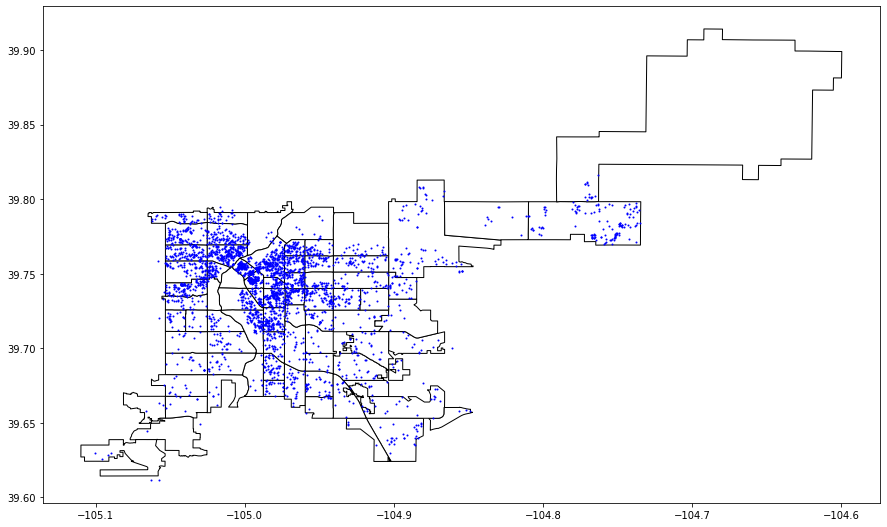

In [23]:
# Plot all the coordinates from the listings on the neighborhoods map
listings_gdf = gpd.GeoDataFrame(listings, geometry="coordinates")

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax = neighborhoods_gdf.plot(color="white", edgecolor="black", ax=ax)
listings_gdf.plot(ax=ax, color="blue", markersize=1)

plt.show()

[Text(0.5, 1.0, 'Listing distributions per Neighborhood Group')]

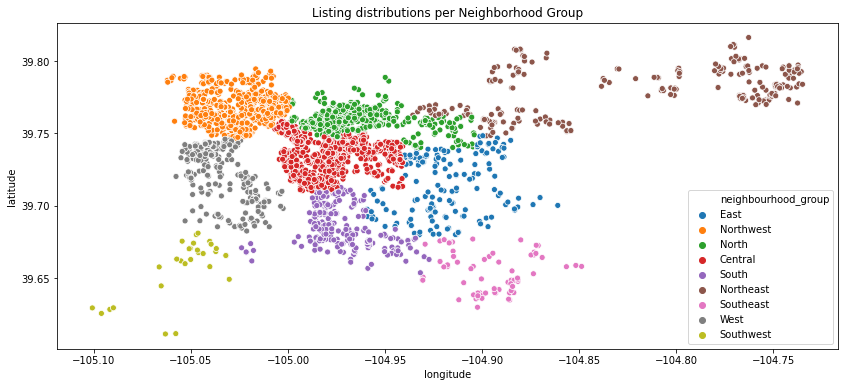

In [24]:
plt.figure(figsize=(14,6))

sns.scatterplot(data=listings, x='longitude', y='latitude', hue='neighbourhood_group').set(title='Listing distributions per Neighborhood Group')

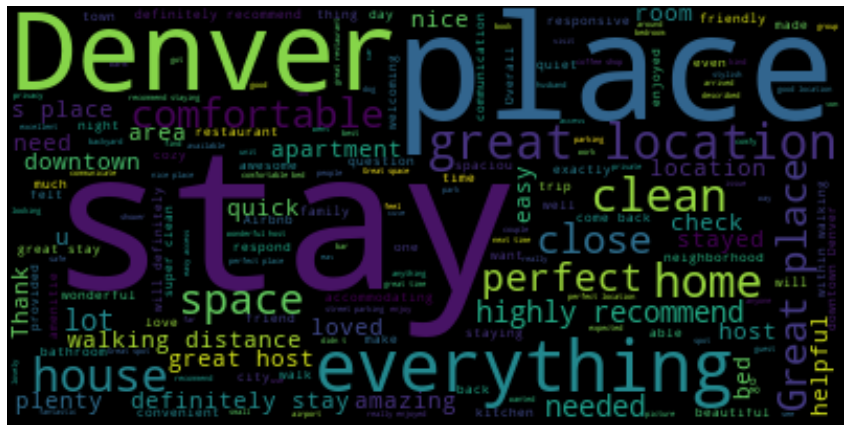

In [25]:
# make a word cloud with all the reviews text

# function to lump all the text together
def lumpText(text_array):
    lump = ""
    for i in text_array:
        lump += str(i) + " "
    return lump

# generate wordcloud
reviews_lump_text = lumpText(reviews["comments"].values)
reviews_wordcloud = WordCloud().generate(reviews_lump_text)

# plot
plt.figure(figsize=(15,10))
plt.imshow(reviews_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Listings Accomdiates

[Text(0.5, 1.0, 'Listings Accomdiates(Num of People)')]

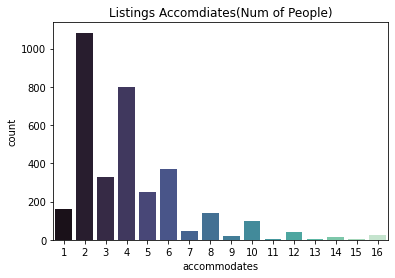

In [26]:
sns.countplot(x=listings.accommodates, palette="mako").set(title='Listings Accomdiates(Num of People)')

### Listings Price

count    3393.000000
mean      157.756263
std       244.777158
min        22.000000
25%        79.000000
50%       115.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64


[Text(0.5, 1.0, 'listings Price Distribution')]

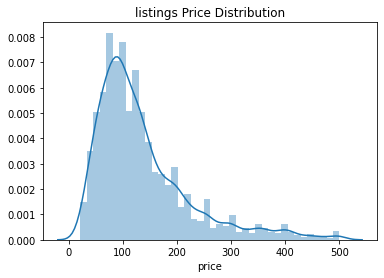

In [27]:
print(listings['price'].describe())
listings_price_500 = listings[listings['price']<=500]
sns.distplot(listings_price_500.price, kde=True).set(title = 'listings Price Distribution')

### Listing proportion by Neighbourhood Group 

Text(0.5, 1.0, 'Listing Proportion by Neighbourhood_group')

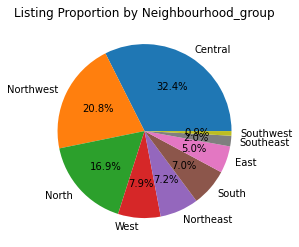

In [28]:
plt.pie(listings.neighbourhood_group.value_counts(), 
        labels=listings.neighbourhood_group.value_counts().index, 
        autopct='%1.1f%%')

plt.title('Listing Proportion by Neighbourhood_group')

### Neighbourhood price box plot


,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Central,1072.00,136.69,76.88,29.00,82.75,119.00,171.00,499.00
East,164.00,111.23,74.98,23.00,64.75,81.00,140.25,408.00
North,552.00,138.89,89.69,29.00,80.00,116.00,164.00,495.00
Northeast,242.00,108.25,84.90,22.00,48.25,80.00,136.75,464.00
Northwest,682.00,148.87,92.00,25.00,90.00,120.00,179.00,499.00
South,232.00,129.44,82.78,25.00,75.00,106.00,150.00,485.00
Southeast,66.00,112.80,96.97,24.00,50.00,77.50,119.75,400.00
Southwest,28.00,127.18,102.63,29.00,69.50,86.50,143.00,416.00
West,262.00,138.46,90.33,24.00,75.00,119.50,176.75,450.00


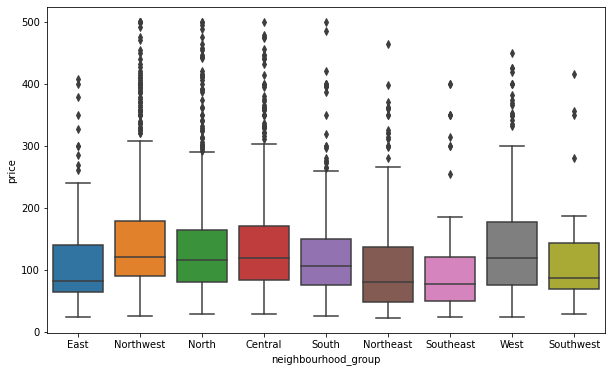

In [29]:
plt.figure(figsize=(10,6))
sns.boxplot(y='price',x='neighbourhood_group', data = listings[listings['price']<=500])

pd.options.display.float_format = "{:.2f}".format
listings[listings['price']<500].groupby(['neighbourhood_group'])['price'].describe()

### Room Type

Entire home/apt   0.81
Private room      0.18
Hotel room        0.01
Shared room       0.01
Name: room_type, dtype: float64

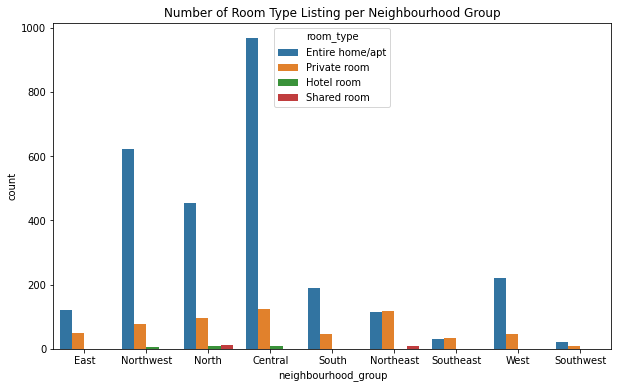

In [30]:
plt.figure(figsize=(10,6))
sns.countplot(x=listings.neighbourhood_group, hue=listings.room_type).set(title='Number of Room Type Listing per Neighbourhood Group')
listings.room_type.value_counts(normalize=True)

### Reviews

<AxesSubplot:xlabel='review_scores_location', ylabel='count'>

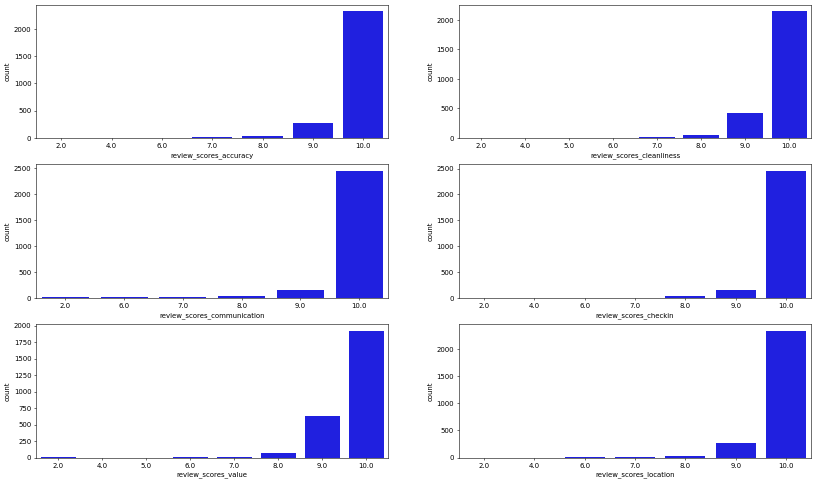

In [32]:
fig, axs = plt.subplots(3, 2, figsize=(20, 12), dpi=50)

sns.countplot(x=listings["review_scores_accuracy"].dropna(),color='b', ax=axs[0, 0])
sns.countplot(x=listings["review_scores_cleanliness"].dropna(),color='b', ax=axs[0, 1])
sns.countplot(x=listings["review_scores_communication"].dropna(),color='b', ax=axs[1, 0])
sns.countplot(x=listings["review_scores_checkin"].dropna(),color='b', ax=axs[1, 1])
sns.countplot(x=listings["review_scores_value"].dropna(),color='b', ax=axs[2, 0])
sns.countplot(x=listings["review_scores_location"].dropna(),color='b', ax=axs[2, 1])

In [17]:
neighbourhood_group_table = listings.groupby('neighbourhood_group')['number_of_reviews'].agg(['sum', 'count']).rename(columns={'count':'Total_Listings', 'sum': 'Total_Reviews'})
neighbourhood_group_table['Listings_w_Reviews'] = listings.groupby('neighbourhood_group')['number_of_reviews'].apply(lambda x: x[x>2].count())
neighbourhood_group_table['%_Listings_with_Reveiws'] = neighbourhood_group_table.Listings_w_Reviews/neighbourhood_group_table.Total_Listings
neighbourhood_group_table

,Total_Reviews,Total_Listings,Listings_w_Reviews,%_Listings_with_Reveiws
neighbourhood_group,,,,
Central,50809,1043,683,0.654842
East,7510,159,120,0.754717
North,40083,548,459,0.837591
Northeast,12815,237,173,0.729958
Northwest,40742,679,528,0.777614
South,11320,225,174,0.773333
Southeast,1825,64,40,0.625000
Southwest,1517,27,20,0.740741
West,11194,257,193,0.750973


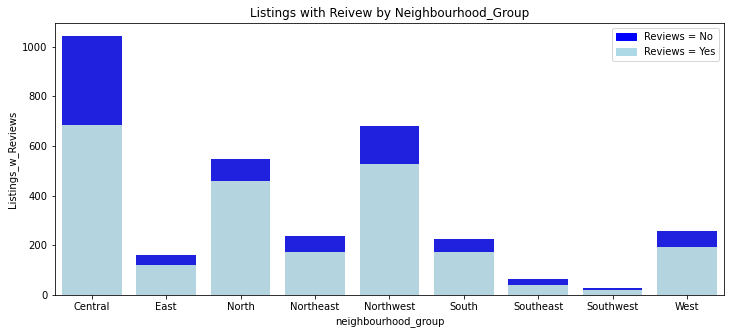

In [31]:
plt.figure(figsize=(12,5))
sns.barplot(data=neighbourhood_group_table, x=neighbourhood_group_table.index, y=neighbourhood_group_table.Total_Listings, color='blue')
sns.barplot(data=neighbourhood_group_table, x=neighbourhood_group_table.index, y=neighbourhood_group_table.Listings_w_Reviews, color='lightblue').set(title='Listings with Reivew by Neighbourhood_Group')

top_bar = mpatches.Patch(color='blue', label='Reviews = No')
bottom_bar = mpatches.Patch(color='lightblue', label='Reviews = Yes')
plt.legend(handles=[top_bar, bottom_bar])

### Fillna for numerical features

In [35]:
#Numeric columns :
numFeatures = listings.select_dtypes(include=['int64', 'float64']).columns
numFeatures

Index(['id', 'host_id', 'host_since', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private

In [36]:
listings[numFeatures] = listings[numFeatures].fillna(listings[numFeatures].mean()) # fill numberical columns with mean

# Model

### Convert Categoircal Features to Numberic with LabelEncoder()

In [58]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values
for cat in catFeatures:
    # Save neighbourhoog_group_mapping for later
    listings[cat] = labelencoder.fit_transform(listings[cat])
    if cat == 'neighbourhood_group':
        neighbourhood_group_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))

listings[catFeatures].sample(3)

,host_location,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,has_availability,instant_bookable,...,Shared outdoor heated pool,Shared outdoor heated rooftop pool,Shared outdoor pool,Shared pool,Shared sauna,TV,Washer,Wifi,Window AC unit,neighbourhood_group
45,35,3,0,1,1,8,4,0,1,0,...,0,0,0,0,0,1,1,1,0,0
2837,35,4,0,1,1,40,6,0,1,1,...,0,0,0,0,0,1,0,1,0,0
2118,4,4,0,1,1,71,8,0,1,1,...,0,0,0,0,0,1,1,1,0,1


### Splitting data into test train

In [43]:
from sklearn.model_selection import train_test_split

# Dependent variable: neighbourhood_group
y = listings['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates', 'longitude', 'latitude'], axis=1)

In [34]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Fit Initial Model

In [35]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=50)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

In [36]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 8, ..., 4, 2, 4])

## Model Evaluation

In [37]:
from sklearn import metrics

# First evaluate inital model to get a feel of the metrics
print('n_estimators = 50')
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators = 50
	Mean Absolute Error: 1.6601178781925343
	Mean Squared Error: 6.567779960707269
	Root Mean Squared Error: 2.5627680270963404


In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[246   1  29   2  47   1   1   0   0]
 [ 25   3   1   5  12   1   1   0   0]
 [ 56   0  56   9  63   0   0   0   4]
 [ 15   0   9  26  15   0   2   0   0]
 [ 77   1  18   3 103   0   0   0   6]
 [ 22   0   7   4  27   8   0   0   0]
 [  7   0   2   4   0   0   5   0   0]
 [  1   0   1   0   3   0   0   1   0]
 [ 20   0   8   3  37   1   1   0  18]]
              precision    recall  f1-score   support

           0       0.52      0.75      0.62       327
           1       0.60      0.06      0.11        48
           2       0.43      0.30      0.35       188
           3       0.46      0.39      0.42        67
           4       0.34      0.50      0.40       208
           5       0.73      0.12      0.20        68
           6       0.50      0.28      0.36        18
           7       1.00      0.17      0.29         6
           8       0.64      0.20      0.31        88

    accuracy                           0.46      1018
   macro avg       0.58      0.31      0.34      101

In [39]:
# Make Evaluation Dataframe
evaluation = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation.shape[0]
    evaluation.loc[r] = [i,mae,mse,rmse,accuracy]

In [40]:
# Show evaluation dataframe
evaluation.sample(3)

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
1,10.00,1.83,7.80,2.79,0.44
37,190.00,1.63,6.43,2.54,0.47
25,130.00,1.58,6.26,2.50,0.48


<AxesSubplot:xlabel='n_estimators'>

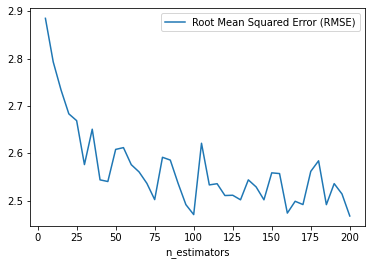

In [41]:
# Plot RMSE
evaluation.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

<AxesSubplot:xlabel='n_estimators'>

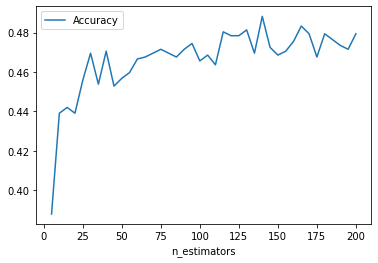

In [42]:
# Plot Accuracy
evaluation.plot(kind='line',x='n_estimators',y='Accuracy')

<AxesSubplot:xlabel='n_estimators'>

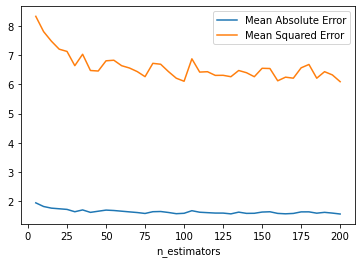

In [43]:
# Plot other Metrics
evaluation.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

## Model Selection

In [44]:
# Get row in dataframe where accuracy was the highest
best_model = evaluation.sort_values(by = "Accuracy", ascending = False).head(1)
best_model

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
27,140.00,1.59,6.40,2.53,0.49


In [45]:
best_n = int(best_model['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n)

We saw best performace on a RandomForestClassifier with n_estimators =  140


In [46]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=140)

In [47]:
y_pred = rf.predict(X_test)
y_pred

array([2, 0, 8, ..., 4, 2, 4])

In [48]:
print('n_estimators = ', best_n)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  140
	Mean Absolute Error: 1.5884086444007859
	Mean Squared Error: 6.150294695481336
	Root Mean Squared Error: 2.4799787691593926


In [49]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuracy: ", accuracy_score(y_test, y_pred))

[[242   0  20   2  61   1   1   0   0]
 [ 20   3   4   4  15   0   1   0   1]
 [ 49   1  64   7  63   1   0   0   3]
 [ 12   0   5  28  20   0   1   0   1]
 [ 64   1  18   2 119   0   0   0   4]
 [ 21   0   9   5  24   8   0   0   1]
 [  6   0   3   3   1   0   5   0   0]
 [  1   0   0   0   4   0   0   1   0]
 [ 12   0  14   1  38   2   1   0  20]]
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       327
           1       0.60      0.06      0.11        48
           2       0.47      0.34      0.39       188
           3       0.54      0.42      0.47        67
           4       0.34      0.57      0.43       208
           5       0.67      0.12      0.20        68
           6       0.56      0.28      0.37        18
           7       1.00      0.17      0.29         6
           8       0.67      0.23      0.34        88

    accuracy                           0.48      1018
   macro avg       0.60      0.32      0.36      101

In [50]:
# Create DatFrame of Feature importance for our best model.
feature_importance = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance.columns = ['importance']
feature_importance = feature_importance.sort_values(by = 'importance', ascending = False)

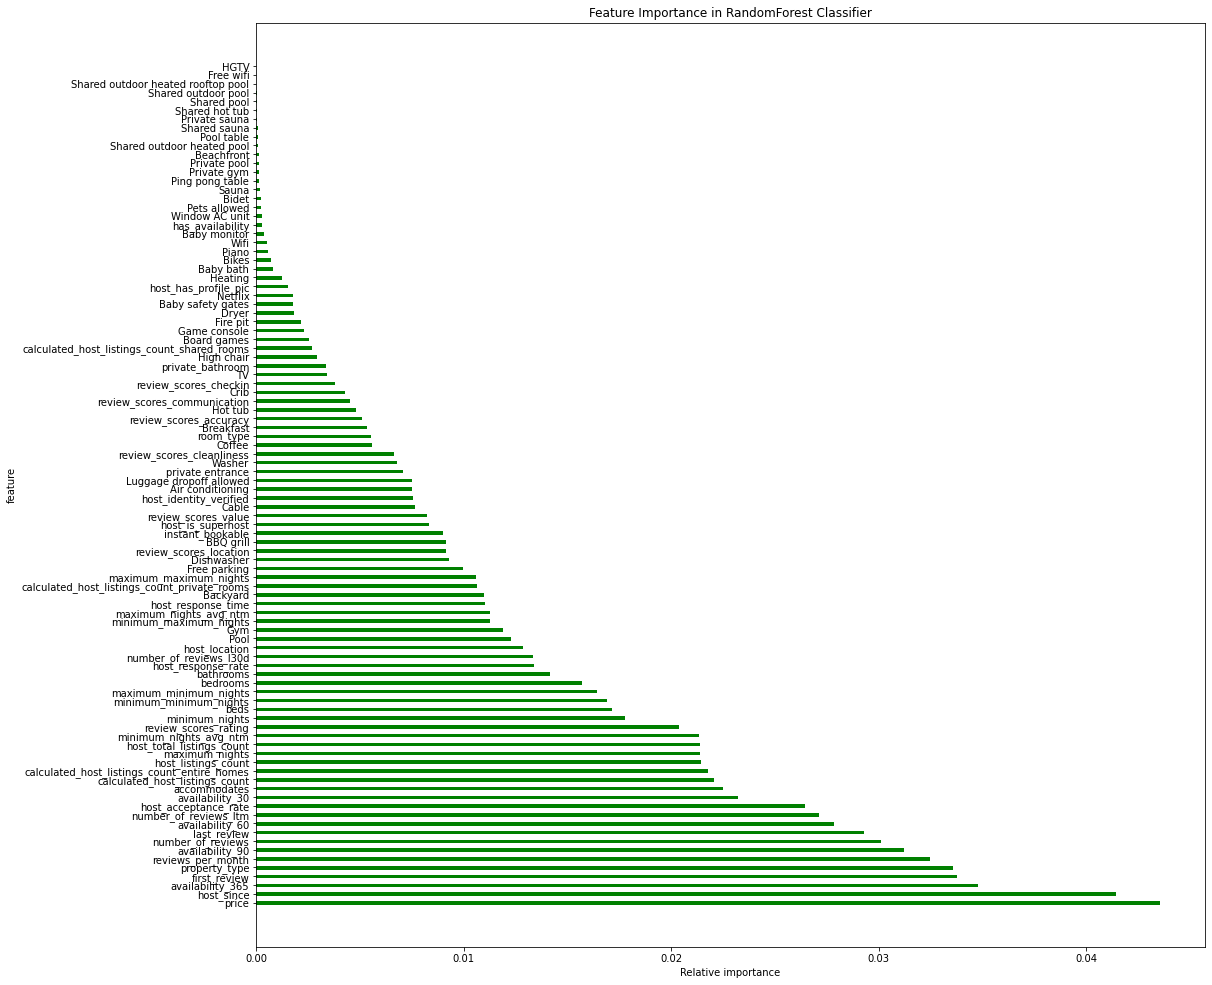

<Figure size 1224x1224 with 0 Axes>

In [51]:
col = feature_importance.index
y = feature_importance.importance

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

## Models with Iscolated Neighbourhoods

### Northwest, West, North

Because the highest accuracy we saw was still under 50% when choosing between 9 neighbourhoods groups. Lets try to iscolate it to 3 nighbourhoods. And since ```price``` was the most importance feature, lets use the ```neighbourhood_groups``` ```Northwest```, ```West```, & ```North``` because they had the highest mean prices, similar median prices, and are all next to each other.

In [52]:
# First we have to check out out categorical mapping from earlier to know what categories these neighbourhoods are in
neighbourhood_group_mapping

{'Central': 0,
 'East': 1,
 'North': 2,
 'Northeast': 3,
 'Northwest': 4,
 'South': 5,
 'Southeast': 6,
 'Southwest': 7,
 'West': 8}

In [53]:
listings_iso = listings.loc[listings["neighbourhood_group"].isin([neighbourhood_group_mapping["Northwest"], neighbourhood_group_mapping["West"], neighbourhood_group_mapping["North"]])]

# Dependent variable: neighbourhood_group
y = listings_iso['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings_iso.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates', 'longitude', 'latitude'], axis=1)

In [54]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Model Evaluation 

In [55]:
# Do same process as before where we find best n_estimator in a for loop
evaluation_iso = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation_iso.shape[0]
    evaluation_iso.loc[r] = [i,mae,mse,rmse,accuracy]

<AxesSubplot:xlabel='n_estimators'>

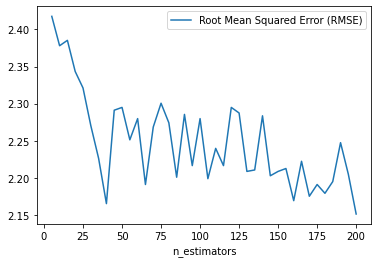

In [56]:
# Plot RMSE
evaluation_iso.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

<AxesSubplot:xlabel='n_estimators'>

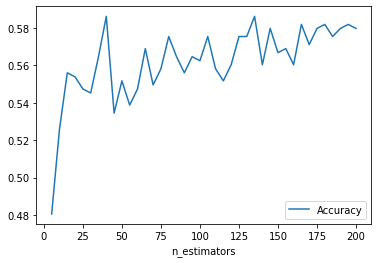

In [57]:
# Plot Accuracy
evaluation_iso.plot(kind='line',x='n_estimators',y='Accuracy')

<AxesSubplot:xlabel='n_estimators'>

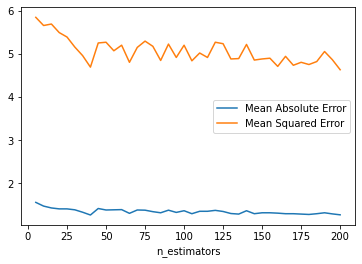

In [58]:
# Plot other Metrics
evaluation_iso.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

### Model Selection

In [59]:
# Get row in dataframe where accuracy was the highest
best_model_iso = evaluation_iso.sort_values(by = "Accuracy", ascending = False).head(1)
best_model_iso

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
7,40.00,1.26,4.69,2.17,0.59


In [60]:
best_n_iso = int(best_model_iso['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n_iso)

We saw best performace on a RandomForestClassifier with n_estimators =  40


In [61]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n_iso)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=40)

In [62]:
y_pred = rf.predict(X_test)
y_pred

array([4, 2, 4, 4, 2, 4, 4, 4, 2, 2, 2, 4, 8, 4, 4, 4, 2, 4, 2, 4, 4, 4,
       4, 4, 4, 4, 8, 4, 8, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 8,
       4, 4, 2, 2, 4, 4, 4, 2, 2, 4, 4, 4, 4, 8, 4, 2, 4, 2, 4, 4, 2, 2,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 8, 4, 2, 4, 4, 2, 2, 4, 2, 4, 4, 4, 4,
       4, 8, 4, 2, 4, 2, 2, 4, 2, 8, 8, 8, 2, 2, 4, 2, 4, 4, 8, 4, 4, 4,
       2, 4, 2, 8, 2, 2, 4, 4, 4, 4, 8, 4, 2, 4, 8, 2, 4, 2, 4, 4, 4, 4,
       4, 2, 2, 2, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 2, 2, 4, 4, 2, 8,
       4, 4, 4, 4, 2, 4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 2, 4, 4, 4, 4,
       4, 4, 2, 2, 4, 8, 2, 2, 4, 2, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 4, 4,
       4, 4, 4, 4, 4, 4, 2, 2, 4, 4, 2, 4, 2, 4, 4, 8, 2, 4, 4, 8, 4, 4,
       4, 2, 4, 4, 4, 2, 2, 4, 2, 2, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       2, 4, 2, 4, 4, 4, 4, 2, 4, 2, 2, 4, 4, 2, 2, 2, 4, 4, 8, 2, 4, 4,
       8, 2, 2, 4, 4, 4, 4, 2, 8, 4, 4, 4, 8, 2, 4, 2, 4, 4, 4, 4, 4, 2,
       2, 4, 4, 2, 4, 4, 4, 2, 2, 4, 2, 4, 2, 2, 2,

In [63]:
print('n_estimators = ', best_n_iso)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  40
	Mean Absolute Error: 1.3577586206896552
	Mean Squared Error: 5.146551724137931
	Root Mean Squared Error: 2.2686012704170673


In [64]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuray: ", accuracy_score(y_test, y_pred))

[[ 87  84   5]
 [ 42 154   5]
 [ 26  43  18]]
              precision    recall  f1-score   support

           2       0.56      0.49      0.53       176
           4       0.55      0.77      0.64       201
           8       0.64      0.21      0.31        87

    accuracy                           0.56       464
   macro avg       0.58      0.49      0.49       464
weighted avg       0.57      0.56      0.53       464

Final Accuray:  0.5581896551724138


In [65]:
# Create DatFrame of Feature importance for our best model.
feature_importance = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance.columns = ['importance']
feature_importance = feature_importance.sort_values(by = 'importance', ascending = False)

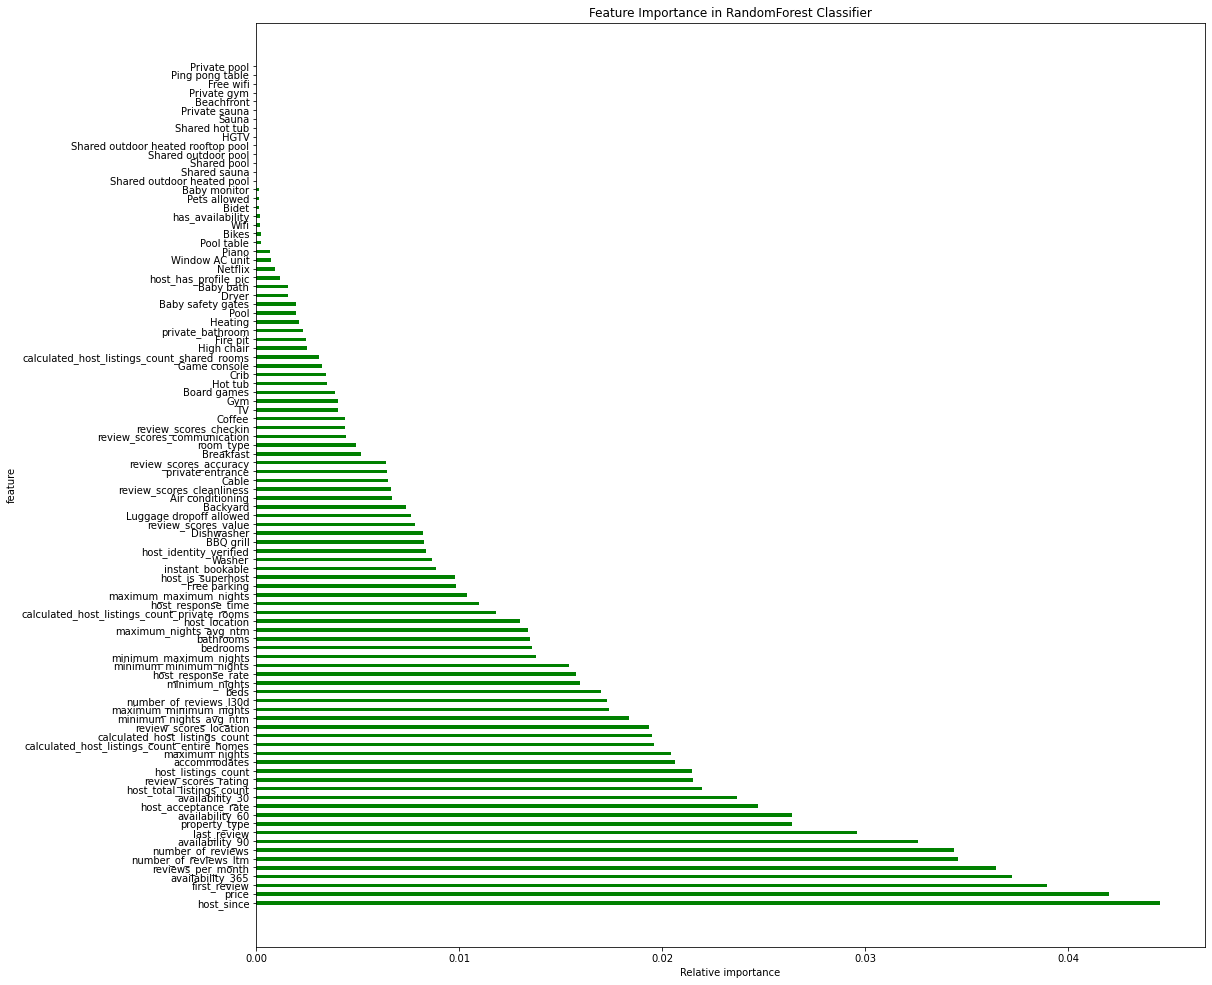

<Figure size 1224x1224 with 0 Axes>

In [66]:
col = feature_importance.index
y = feature_importance.importance

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)

By isolating the neighbourhood groups the accuracy went up by over 10%! 

### Central, Northeast, Southwest

Now lets try running the model with ```neighbourhood_group```s that are further apart. 

In [67]:
listings_iso = listings.loc[listings["neighbourhood_group"].isin([neighbourhood_group_mapping["Central"], neighbourhood_group_mapping["Northeast"], neighbourhood_group_mapping["Southwest"]])]

# Dependent variable: neighbourhood_group
y = listings_iso['neighbourhood_group']

# Drop dependent variable and other variables that would tamper the results
X = listings_iso.drop(['neighbourhood_group', 'id', 'host_id', 'neighbourhood_cleansed', 'coordinates', 'longitude', 'latitude'], axis=1)

In [68]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [69]:
# Do same process as before where we find best n_estimator in a for loop
evaluation_iso = pd.DataFrame({'n_estimators': [],
                           'Mean Absolute Error':[],
                           'Mean Squared Error':[],
                           'Root Mean Squared Error (RMSE)':[],
                           'Accuracy':[]})

# Make for loop to graph RMSE & Accuracy for different n_estimators
for i in range(5, 201, 5):
    # Make Classifier & Fit
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = rf.predict(X_test)
    
    # Calculate metrics
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    
    # append to evaluation data frame
    r = evaluation_iso.shape[0]
    evaluation_iso.loc[r] = [i,mae,mse,rmse,accuracy]

<AxesSubplot:xlabel='n_estimators'>

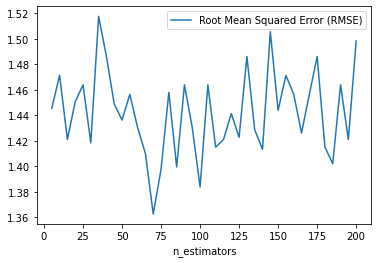

In [70]:
# Plot RMSE
evaluation_iso.plot(kind='line',x='n_estimators',y='Root Mean Squared Error (RMSE)')

<AxesSubplot:xlabel='n_estimators'>

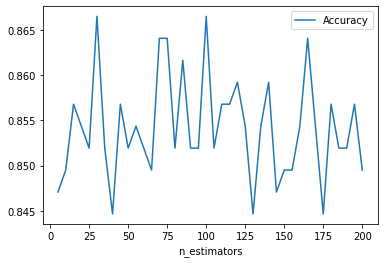

In [71]:
# Plot Accuracy
evaluation_iso.plot(kind='line',x='n_estimators',y='Accuracy')

<AxesSubplot:xlabel='n_estimators'>

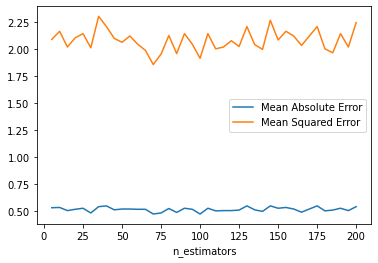

In [72]:
# Plot other Metrics
evaluation_iso.plot(kind='line',x='n_estimators',y=['Mean Absolute Error', 'Mean Squared Error'])

In [73]:
# Get row in dataframe where accuracy was the highest
best_model_iso = evaluation_iso.sort_values(by = "Accuracy", ascending = False).head(1)
best_model_iso

,n_estimators,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error (RMSE),Accuracy
19,100.00,0.47,1.92,1.38,0.87


In [74]:
best_n_iso = int(best_model_iso['n_estimators'].iloc[0])
print("We saw best performace on a RandomForestClassifier with n_estimators = ", best_n_iso)

We saw best performace on a RandomForestClassifier with n_estimators =  100


In [75]:
# Create a Gaussian Classifier
rf=RandomForestClassifier(n_estimators=best_n_iso)

# Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_train,y_train)

RandomForestClassifier()

In [76]:
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 7, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0,
       0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
print('n_estimators = ', best_n_iso)
print('\tMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('\tMean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('\tRoot Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

n_estimators =  100
	Mean Absolute Error: 0.5024271844660194
	Mean Squared Error: 2.0606796116504853
	Root Mean Squared Error: 1.4355067438540599


In [78]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print("Final Accuray: ", accuracy_score(y_test, y_pred))

[[318   3   0]
 [ 46  35   0]
 [  8   1   1]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       321
           3       0.90      0.43      0.58        81
           7       1.00      0.10      0.18        10

    accuracy                           0.86       412
   macro avg       0.92      0.51      0.56       412
weighted avg       0.87      0.86      0.83       412

Final Accuray:  0.8592233009708737


In [79]:
# Create DatFrame of Feature importance for our best model.
feature_importance = pd.DataFrame(rf.feature_importances_, X.columns)
feature_importance.columns = ['importance']
feature_importance = feature_importance.sort_values(by = 'importance', ascending = False)

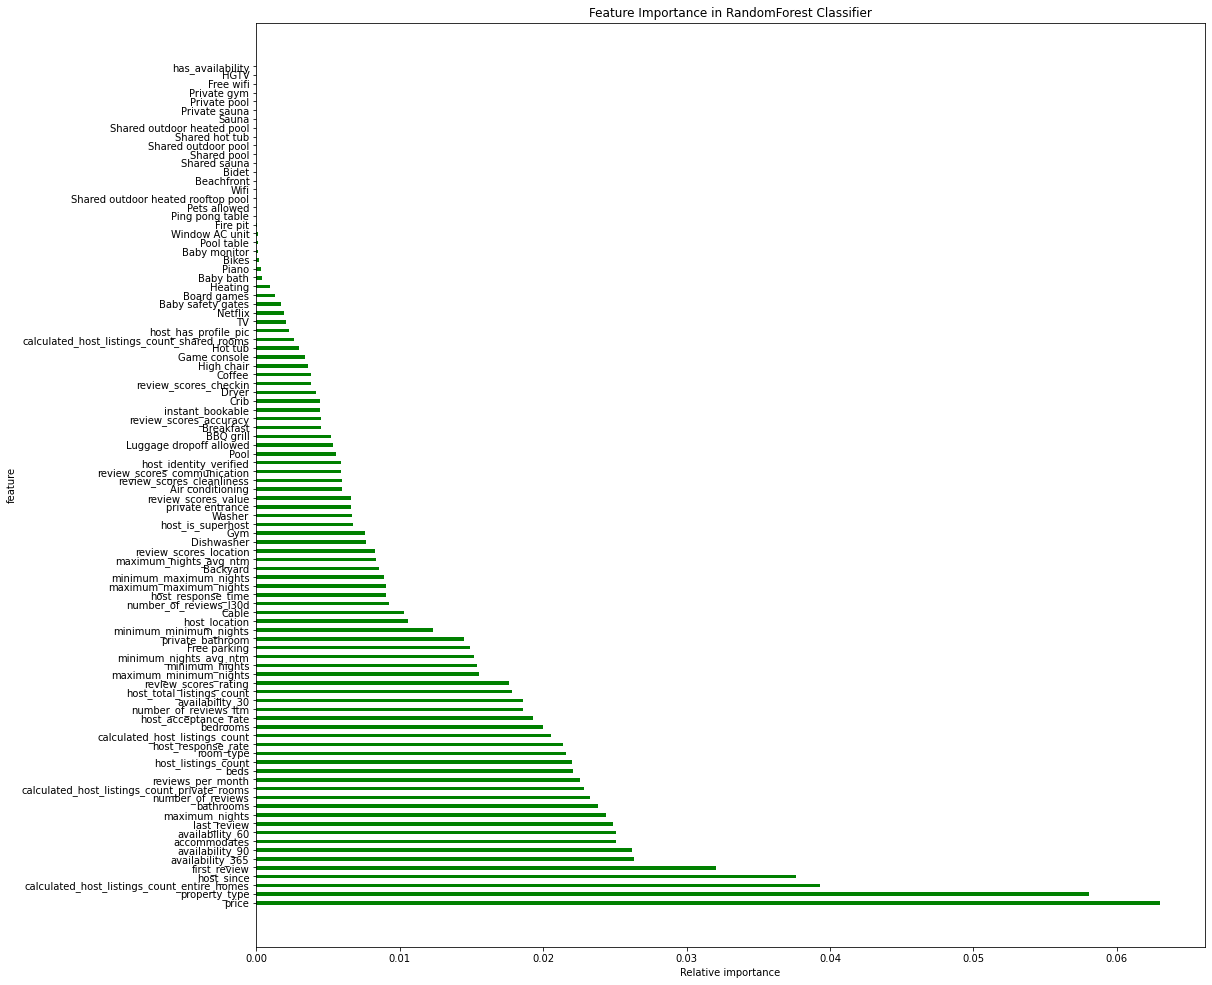

<Figure size 1224x1224 with 0 Axes>

In [80]:
col = feature_importance.index
y = feature_importance.importance

# plot feature_importance
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature Importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(17,17))
fig.set_size_inches(17, 17, forward=True)